#Assignment 6: Q-Learning
##Task 3. Taxi
Laura Quiroga - 201922965

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

#Definición del ambiente

In [ ]:
class Passenger:
  def __init__(self, stations):
    self.start = ""
    i_initial = self.set_initial_station(stations)
    self.destiny = self.set_destiny(stations, i_initial)

  def set_initial_station(self, stations):
    i_stations = np.random.randint(len(stations))
    self.start = stations[i_stations][1]
    return i_stations
  
  def set_destiny(self, stations, start):
    st_copy = stations.copy()
    st_copy.pop(start)
    i_destiny = np.random.randint(len(stations)-1)
    return st_copy[i_destiny][1]


In [ ]:
class Environment:
  def __init__(self, board=[], stops=[]):
    self.board = board
    self.stations = np.zeros_like(self.board, dtype=object)
    self.stations_names = [""]
    for s in stops:
      sx=s[0][0]-1
      sy=s[0][1]-1
      self.stations[sx][sy]=s[1]
      self.stations_names.append(s[1])
    self.passenger = Passenger(stops)

  def new_passenger(self, stations):
    """
    Agrega un pasajero al tablero con un destino fijo
    """
    self.passenger = Passenger(stations)
  
  def start(self):
    """
    Devuelve un estado inicial
    """
    x = np.random.randint(len(self.board))
    y = np.random.randint(len(self.board[0]))
    return (x,y,0)
  
  def dim(self): 
    """
    Devuelve tamanio del tablero
    """
    return [len(self.board), len(self.board[0])]

#Definición del agente

In [ ]:
class Agent:
    def __init__(self, init_state):
      self.state = init_state
      self.actions = ['up', 'right', 'down', 'left', 'pick','drop']

    def  set_state(self, next_state):
      """
      Actualiza el estado actual del agente
      """
      self.state = next_state
  

#Definición de la clase intermediaria

In [ ]:
#Clase que media la interacción entre el agente y su entorno
#Así nos aseguramos de que el agente no conozca lo que no debe conocer de su entorno

class Learner:
    def __init__(self, agent, env, alpha=0.5, gamma=0.6, epsilon=0.1):
      #hyper parameters
      self.alpha = alpha
      self.gamma = gamma
      self.epsilon = epsilon
      self.env = env
      self.agent = agent          #actual agent
      self.qtable = self.__initdic__() #rewards table
      #initiate random policy
      self.policy = [[[np.random.randint(len(self.agent.actions)) for s in range(len(self.env.stations_names))] for y in range(self.env.dim()[1])] for x in range(self.env.dim()[0])]
    
    def __initdic__(self):
      """
      Inicializa la q-tabla en 0s 
      Dim: x,y,actions
      """
      table = np.zeros((self.env.dim()[0], self.env.dim()[1], len(self.env.stations_names), len(self.agent.actions)), dtype=object)
      return table


    def run(self):
      done = False
      while not done:
          current_state = self.agent.state

          # Con prob epsilon: toma acción aleatoria
          if random.uniform(0,1) < self.epsilon:
              action = self.randomAction()
          # Con prob 1-epsilon: toma mejor acción según q-tabla
          else:
              action = self.choose_best_action(current_state)

          next_state, reward, done, info = self.step(action)
          old_value = self.qtable[current_state[0],current_state[1],current_state[2]][action]
          next_max = np.max(self.qtable[next_state[0], next_state[1], next_state[2]])

          #compute q_value(s, a, t): (1-alpha) *q_value(s, a, t-1)+ apha*(r + gamma * max_q_value(s', t))
          new_value = (1 - self.alpha)*old_value + self.alpha*(reward + self.gamma*next_max)
          self.qtable[current_state[0],current_state[1],current_state[2]][action] = new_value

          #print(info) #formated result
          #print(f'{current_state}, {action}, {next_state}')
      new_policy = self.calculate_policy()
      converged = self.check_convergence(new_policy)
      self.policy = new_policy
    
      return converged

    
    def calculate_policy(self):
      """
      Calcula la política para cada estado
      """
      policy = np.zeros((self.env.dim()[0], self.env.dim()[1], len(self.env.stations_names)), dtype=object)
      for x in range(self.env.dim()[0]):
        for y in range(self.env.dim()[1]):
          for s in range(len(self.env.stations_names)):
            policy[x][y][s]=self.choose_best_action((x,y,s))
      return policy

    def check_convergence(self, new_policy)->bool:
      converged = True
      for x in range(self.env.dim()[0]):
        for y in range(self.env.dim()[1]):
          for s in range(1, len(self.env.stations_names)):
            if self.policy[x][y][s]!=new_policy[x][y][s]:
              return False
      return converged

    def randomAction(self):
      return random.randint(0,len(self.agent.actions)-1)
    
    def choose_best_action(self, current_state):
      """
      Escoge la mejor acción según los valores de la q_tabla
      Si hay empate, escoge aleatoriamente entre las acciones óptimas
      """
      q_values = self.qtable[current_state[0]][current_state[1]][current_state[2]]
      max_q_value = -math.inf
      best_actions = []
      for i in range(len(q_values)):
        if q_values[i]>max_q_value:
          max_q_value = q_values[i]
          best_actions.clear()
          best_actions.append(i)
        elif q_values[i]==max_q_value:
          best_actions.append(i)
      if self.policy[current_state[0]][current_state[1]][current_state[2]] in best_actions:
        return self.policy[current_state[0]][current_state[1]][current_state[2]]
      return np.random.choice(best_actions)

    def step(self, i_action):
      """
      Ejecuta la acción dada a partir del estado actual del agente
      """
      old_state = self.agent.state
      action = self.agent.actions[i_action]
      next_state, reward, done = self.takeAction(old_state, action)

      info = f'Executed action: {action}. From {old_state} to {next_state}. Reward: {reward} Terminal: {done}'
      return next_state, reward, done, info

    def takeAction(self, state, action):
      max_x = self.env.dim()[0]-1
      max_y = self.env.dim()[1]-1
      done = False

      reward = 0

      #si la casilla nueva no es pisable (hay pared) ->next_state=state
      if self.env.board[state[0]][state[1]]=='w' and action=="right":
        next_state=state
      
      else:
        if action == "up":
          next_state = (state[0], max(state[1]-1, 0), state[2])
        elif action == "down":
          next_state = (state[0], min(state[1]+1, max_y), state[2])
        elif action == "left":
          next_state = (max(state[0]-1,0), state[1], state[2])
          #si la casilla nueva no es pisable (hay pared) ->next_state=state
          if self.env.board[next_state[0]][next_state[1]]=='w':
            next_state= state
        elif action == "right":
          next_state = (min(state[0]+1, max_x), state[1], state[2])
        elif action == "pick":
          has_passenger = (state[2]!=0)
          current_station = self.env.stations[state[0]][state[1]]
          if has_passenger or current_station!=self.env.passenger.start:
            reward = -10
            next_state = state
          else:
            reward = 1
            index_station = self.env.stations_names.index(self.env.passenger.destiny)
            next_state = (state[0],state[1],index_station)
        elif action == "drop":
          has_passenger = (state[2]!=0)
          current_station = self.env.stations[state[0]][state[1]]
          if (not has_passenger) or current_station!=self.env.passenger.destiny:
            reward = -10
            next_state = state
          else:
            reward = 5
            index_nostation = self.env.stations_names.index("")
            next_state = (state[0],state[1],index_nostation)
            done = True #Deja un pasajero = termina un episodio
        self.agent.set_state(next_state)

      return next_state, reward, done

#Visualización de resulatados

In [ ]:
def find_max (value_list):
  max_value = -math.inf
  best_index = []
  for i in range(len(value_list)):
    if value_list[i]>max_value:
      max_value = value_list[i]
      best_index.clear()
      best_index.append(i)
    elif value_list[i]==max_value:
      best_index.append(i)
  return np.random.choice(best_index)

In [ ]:
def print_table(results):
  print("Q-table\n")
  dimensions = results[1].dim()
  stations = results[1].stations_names
  d = dict()
  for x in range(dimensions[0]):
    for y in range(dimensions[1]):
      for s in range(len(stations)):
        q_values = [x for x in results[0][x][y][s]]
        d.update({f'{x+1,y+1,stations[s]}': q_values})
  print ("{:<8} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format('State',f'{results[2].actions[0]}',f'{results[2].actions[1]}',
                                             f'{results[2].actions[2]}',f'{results[2].actions[3]}',f'{results[2].actions[4]}',f'{results[2].actions[5]}'))
  for k, v in d.items():
    a1, a2, a3, a4, a5, a6= v
    print ("{:<8} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format(k, value_to_str(a1), 
                                                                    value_to_str(a2), 
                                                                    value_to_str(a3), 
                                                                    value_to_str(a4), 
                                                                    value_to_str(a5), 
                                                                    value_to_str(a6)))

def value_to_str(value)-> str:
  if not value is None:
    return round(value, 6)
  return "None"

def show_results(results):
  n_episodes = results[3]
  #results format: (q_tabla, environment, agent, # of episodes)
  dimensions = results[1].dim()
  stations_list = results[1].stations_names

  for station in range(len(stations_list)):

    grid_x=list(range(1,dimensions[0]+1))
    grid_y=list(range(1,dimensions[1]+1))
    fig, ax = plt.subplots()
    
    values = np.zeros((dimensions[1],dimensions[0]))
    actions = np.zeros((dimensions[1],dimensions[0]), dtype=object)

    for x in range(dimensions[0]):
      for y in range(dimensions[1]):
        max_q_value = find_max(results[0][x][y][station])
        values[y][x]= round(results[0][x][y][station][max_q_value],4)
        actions[y][x] = (results[2].actions[max_q_value])

    im = ax.imshow(values)
    ax.set_xticks(np.arange(len(grid_x)), labels=grid_x)
    ax.set_yticks(np.arange(len(grid_y)), labels=grid_y)
    station_title = ""
    if station==0: 
      station_title = "No passenger"
    else: 
      station_title = f"Heading to station {stations_list[station]}"
    ax.set_title(f"Policy results after evaluation of {n_episodes} episodes - {station_title}")

    # Loop over data dimensions and create text annotations.
    for i in range(len(grid_y)):
        for j in range(len(grid_x)):
          text = ax.text(j, i, f"{str(values[i,j])}\n{actions[i,j]}",
                        ha="center", va="center", color="k")
    plt.clf


    plt.rcParams['figure.figsize'] = [10, 10]
    plt.show()
    plt.clf

  print_table(results)
      


#Ejecución de escenarios de prueba

In [ ]:
def test(states, stations):

    e = Environment(states, stations)
    a = Agent(e.start())
    l = Learner(a, e)

    episodes = 0
    convergence_count = 0
    while convergence_count<50:
        print(f"Episode: {episodes+1}")
        converged = l.run()
        if converged:
          convergence_count+=1
        else:
          convergence_count=0
        e.new_passenger(stations)
        episodes+=1
        print(convergence_count)
    return (l.qtable, e, a, episodes)

In [ ]:
#Ejecutar el escenario de prueba 
#w:=pared a la derecha de la casilla
states_taxi      = [ ['e','e','e','w','w'],
                     ['w','w','e','e','e'],
                     ['e','e','e','w','w'],
                     ['e','e','e','e','e'],
                     ['e','e','e','e','e'] ]
stations = [((1,1),'R'), ((5,1),'G'), ((1,5),'Y'), ((4,5),'B')]
results = test(states_taxi, stations) 

Episode: 1
0
Episode: 2
0
Episode: 3
0
Episode: 4
0
Episode: 5
0
Episode: 6
1
Episode: 7
0
Episode: 8
0
Episode: 9
0
Episode: 10
0
Episode: 11
0
Episode: 12
1
Episode: 13
0
Episode: 14
0
Episode: 15
1
Episode: 16
2
Episode: 17
0
Episode: 18
0
Episode: 19
1
Episode: 20
2
Episode: 21
0
Episode: 22
0
Episode: 23
1
Episode: 24
0
Episode: 25
1
Episode: 26
0
Episode: 27
1
Episode: 28
0
Episode: 29
1
Episode: 30
0
Episode: 31
0
Episode: 32
1
Episode: 33
2
Episode: 34
3
Episode: 35
0
Episode: 36
0
Episode: 37
1
Episode: 38
0
Episode: 39
0
Episode: 40
0
Episode: 41
0
Episode: 42
1
Episode: 43
0
Episode: 44
0
Episode: 45
1
Episode: 46
2
Episode: 47
3
Episode: 48
4
Episode: 49
0
Episode: 50
0
Episode: 51
0
Episode: 52
1
Episode: 53
2
Episode: 54
3
Episode: 55
4
Episode: 56
0
Episode: 57
1
Episode: 58
0
Episode: 59
1
Episode: 60
2
Episode: 61
3
Episode: 62
4
Episode: 63
5
Episode: 64
0
Episode: 65
1
Episode: 66
2
Episode: 67
3
Episode: 68
4
Episode: 69
5
Episode: 70
6
Episode: 71
7
Episode: 72
8
E

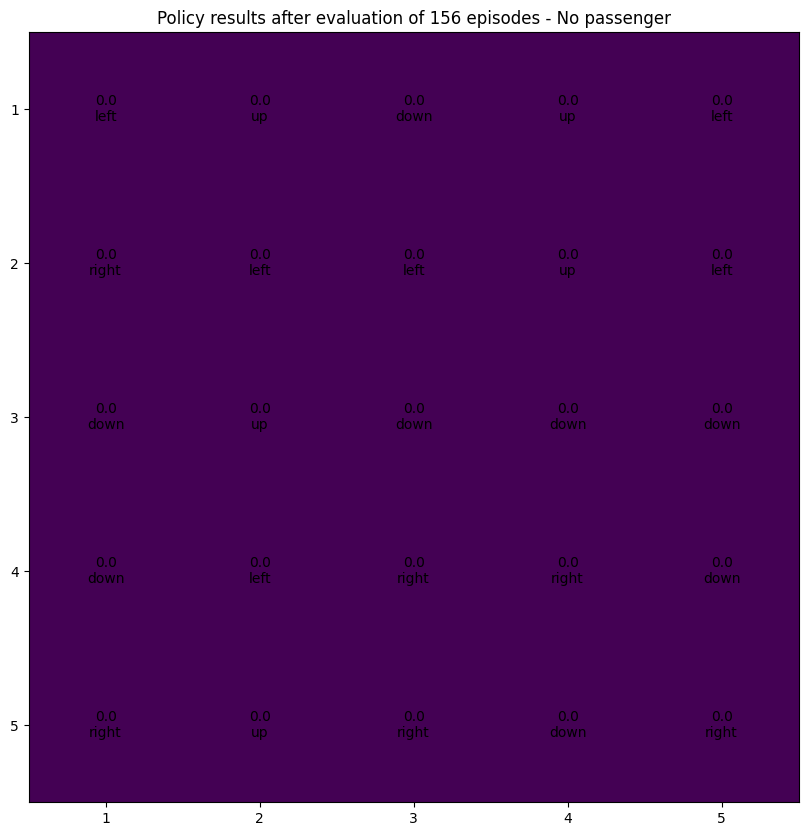

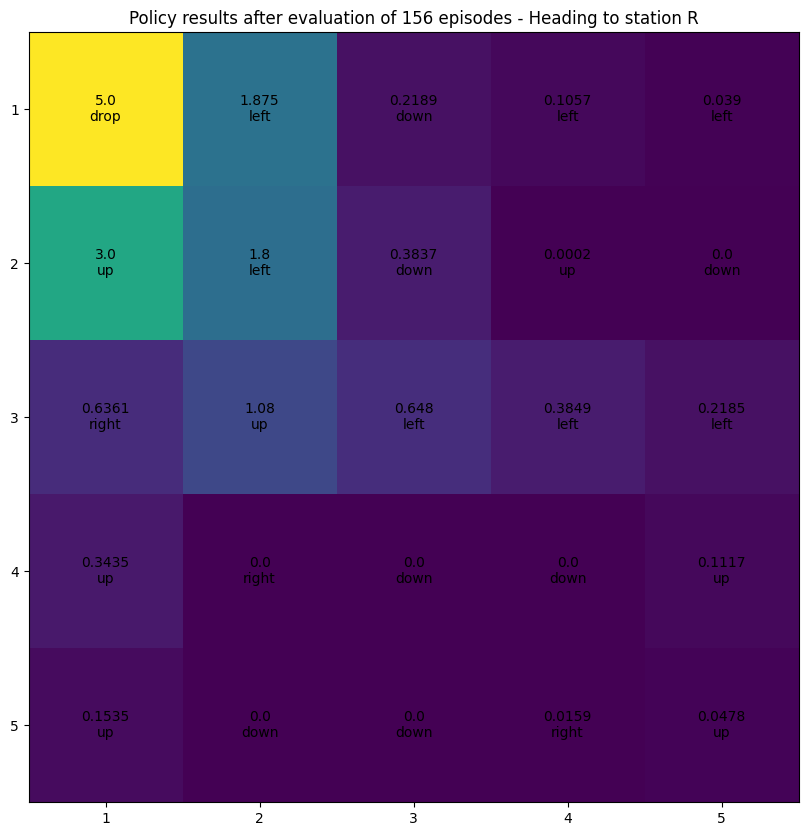

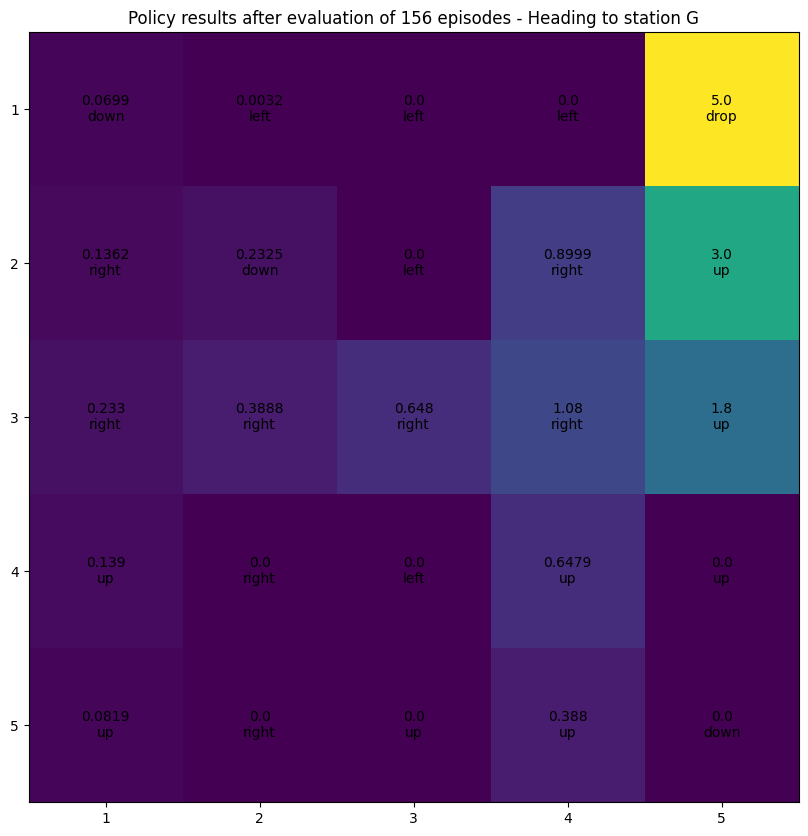

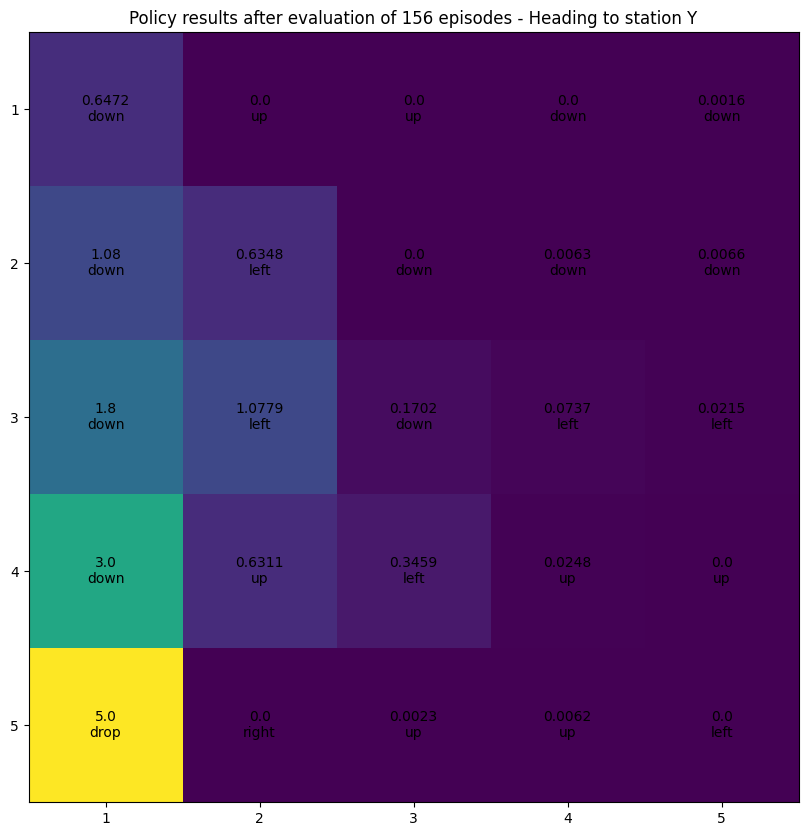

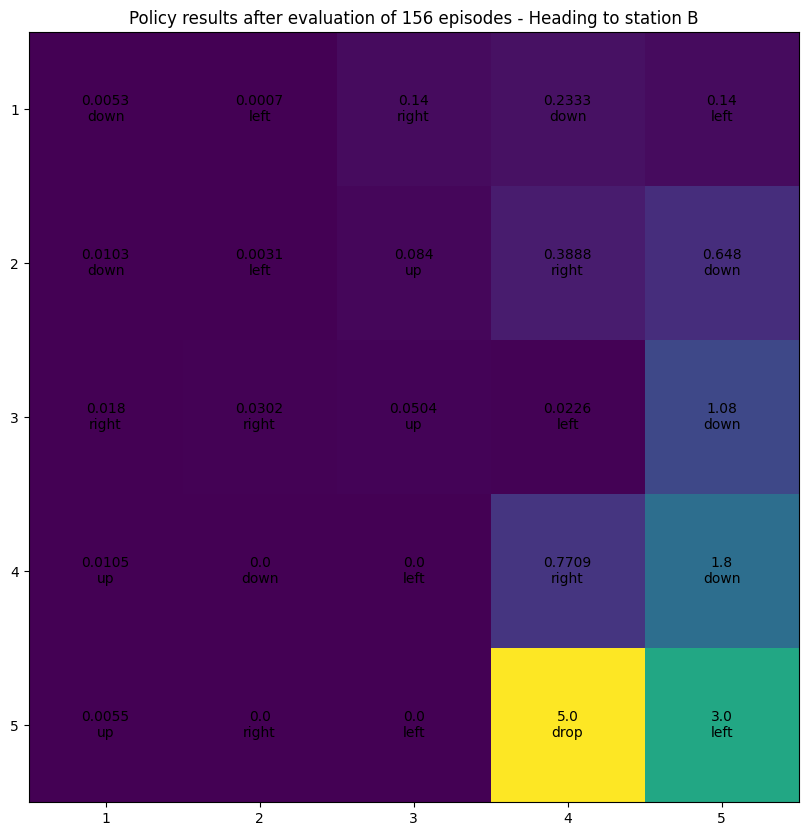

Q-table

State    up              right           down            left            pick            drop           
(1, 1, '') 0.0             0.0             0.0             0.0             -9.827925       -10.0          
(1, 1, 'R') 0               0.0             0.0             0.0             -7.484375       5.0            
(1, 1, 'G') 0.0             0.0             0.069918        0.0             -8.75           -9.375         
(1, 1, 'Y') 0.0             0.0             0.647212        0.0             -10.0           -10.0          
(1, 1, 'B') 0.0             0.0             0.005327        0.0             -9.999268       -9.997559      
(1, 2, '') 0.0             0.0             0.0             0.0             -10.0           -10.0          
(1, 2, 'R') 3.0             0.536111        0.0             0.0             -5.0            -8.75          
(1, 2, 'G') 0.0             0.136152        0.0             0.0             -10.0           -9.999924      
(1, 2, 'Y') 0.14011     

In [ ]:
show_results(results)